# Определение стоимости автомобиля

**Исходные данные:**
данные о технических характеристиках, комплектации и ценах других автомобилей


**Цель:**
построить модели для определения рыночной стоимости автомоблия, критерии качества для модели: качество предсказания, время обучения модели, время предсказания. Значение метрики RMSE менее 2500



**Этапы исследования:**

1. Загрузка исходных данных и их общая оценка
2. Предобработка данных
    * заполнение пропущенных значений
    * обработка аномалий в столбцах 
    * удаление неиформативных признаков
3. Подготовка выборки
4. Обучение и тестирование модели
    * одна из моделей - LightGBM
    * одна из моделей - не бустинг
5. Заключение


## 1 Загрузка исходных данных

In [1]:
!pip install --upgrade matplotlib --quiet install
!pip install seaborn --upgrade --quiet install
!pip install xgboost --quiet install
!pip install lightgbm --quiet install
!pip install optuna --quiet install
!pip install category_encoders --quiet install

In [2]:
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import lightgbm as lgbm
import xgboost as xgb
import category_encoders as ce

from category_encoders.binary import BinaryEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, RobustScaler


RANDOM_STATE = 42

In [3]:
class ShowData:
    '''

    there are the methods for help to look thought the data
    "download_data" open dataset(download) from collab and from other paths,
    "change_data" replaces name of columns according to PEP8 and convert to lower data type,
    "general_info" provides with the numbers of columns/rows, type of columns and occupied memory,
    "deep_info" provides with statistic info and info for preprocessing step,
    "hist_box" shows histograms and boxplots for each numeric column (DON'T FORGET TO CHANGE THE GRAPH SIZE),
    "cor_matrix" shows correlation matrix for all numeric columns, it uses Pearson coefficient

    '''
    def download_data(self, path):

        import os
        if os.path.exists(path):
            df = pd.read_csv(path)
        elif os.path.exist(path):
            from google.colab import drive
            drive.mount('/content/drive')
            df = pd.read_csv(path)
        else:
            print("The path doesn't exist")

        return df

    def change_data(self, df):

        df.columns = (df.columns
                        .str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True)
                        .str.lower())
        try:
            for name in df.select_dtypes("number").columns:
                df[name] = pd.to_numeric(df[name], downcast="float"
                                        if (data["age"] // 1 == 0).all()
                                        else "integer")
        except:
            pass
        return df

    def general_info(self, df):

        info_0 = pd.DataFrame(df.dtypes.value_counts(), columns=[""])
        info_0.loc["columns", ""] = len(df.columns)
        info_0.loc["row", ""] = len(df)
        info_0.loc["memory_usage, MB", ""] = df.memory_usage()\
        .sum() / (1024 ** 2)

        return info_0

    def deep_info(self, df):

        info_1 = pd.DataFrame(index=df.columns, columns=['rows'], data=len(df))
        info_1["null_row"] = (df == 0).sum(axis=0)
        info_1["uniq"] = df.nunique()
        info_1["dup_val"] = [df[i].duplicated().sum() for i in df]
        info_1["dup_row"] = df.duplicated().sum()
        info_1["NaN"] = df.isna().sum()
        info_1["NaN,%"] = df.isna().mean()
        info_1["type"] = df.dtypes
        info_1 = info_1.join(df.describe(include="number")["mean":].transpose())
        info_1.fillna("", inplace=True)
        for col in info_1.loc[:, "mean":]:
            info_1[col] = pd.to_numeric(info_1[col], downcast="float")
        info_1["null_row"] = pd.to_numeric(info_1["null_row"], downcast="integer")
        info_1["outliers"] = info_1["max"] > info_1["75%"] \
                             + 1.5 * (info_1["75%"] - info_1["25%"])

        prop = {
            "border": "0.5px solid black",
            "width": "85px",
            "text-align": "center"
        }
        percent = {
            "NaN,%":"{:.3%}",
            "mean":"{:.3}",
            "std":"{:.3}",
            "min":"{:.3}",
            "25%":"{:.3}",
            "50%":"{:.3}",
            "75%":"{:.3}",
            "max":"{:.3}",
        }

        return info_1, info_1.style.format(percent).set_properties(**prop) 

    def hist_box(self, df):

        length = len(df.columns)
        df_num = df.select_dtypes("number")
        fig = plt.figure(figsize=(length*3,length))
        sfigs = fig.subfigures(round(length/4), 4)
        for i, axes in enumerate(sfigs.flat):
            try:
                axes.suptitle(df_num.columns[i])
                if len(df.iloc[:,i]) > 0:
                    ax_1= axes.subplots(2, 1, sharex=True,
                                        gridspec_kw={"height_ratios": (.15, .85)})
                    sns.boxplot(data=df, x=df_num.columns[i], orient="h",
                                ax=ax_1[0])
                    sns.histplot(data=df, x=df_num.columns[i], kde=True,
                                 ax=ax_1[1])
                    plt.xlabel("")
                    plt.ylabel("")
            except:
                break
        plt.show()

    def cor_matrix(self, df):

        length = len(df.columns)
        plt.figure(figsize=(length/1.5, length/1.5))
        sns.heatmap(df.corr(method="pearson"), annot=True, linewidths=0.3,
            cmap="coolwarm", square=True)
        plt.show()

In [4]:
# create a variable for class
sd = ShowData()
# download data
data = sd.download_data("autos.csv")
# show first 5 rows
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
# invert the data columns to snake case
data = sd.change_data(data)
# look through the general info about data
sd.general_info(data)

,
object,9.000000
int64,7.000000
columns,16.000000
row,354369.000000
"memory_usage, MB",43.258057


In [6]:
info = sd.deep_info(data)[0]
info

,rows,null_row,uniq,dup_val,dup_row,NaN,"NaN,%",type,mean,std,min,25%,50%,75%,max,outliers
date_crawled,354369,0,271174,83195,4,0,0.000000,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
price,354369,10772,3731,350638,4,0,0.000000,int64,4416.656738,4514.158691,0.0,1050.0,2700.0,6400.0,20000.0,True
vehicle_type,354369,0,8,354360,4,37490,0.105794,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
registration_year,354369,0,151,354218,4,0,0.000000,int64,2004.234497,90.227959,1000.0,1999.0,2003.0,2008.0,9999.0,True
gearbox,354369,0,2,354366,4,19833,0.055967,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
power,354369,40225,712,353657,4,0,0.000000,int64,110.094337,189.850403,0.0,69.0,105.0,143.0,20000.0,True
model,354369,0,250,354118,4,19705,0.055606,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
kilometer,354369,0,13,354356,4,0,0.000000,int64,128211.171875,37905.339844,5000.0,125000.0,150000.0,150000.0,150000.0,False
registration_month,354369,37352,13,354356,4,0,0.000000,int64,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0,False
fuel_type,354369,0,7,354361,4,32895,0.092827,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [7]:
data.head(2)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50


In [8]:
data.isna().sum().sum()/data.shape[0] * 100

51.09843129619126

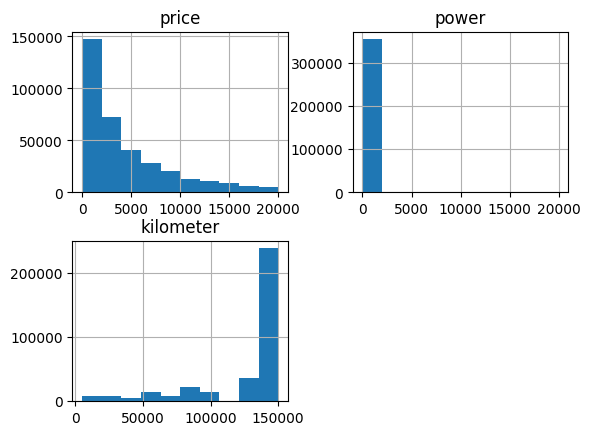

In [9]:
data[["price", "power", "kilometer" ]].hist()
plt.show()

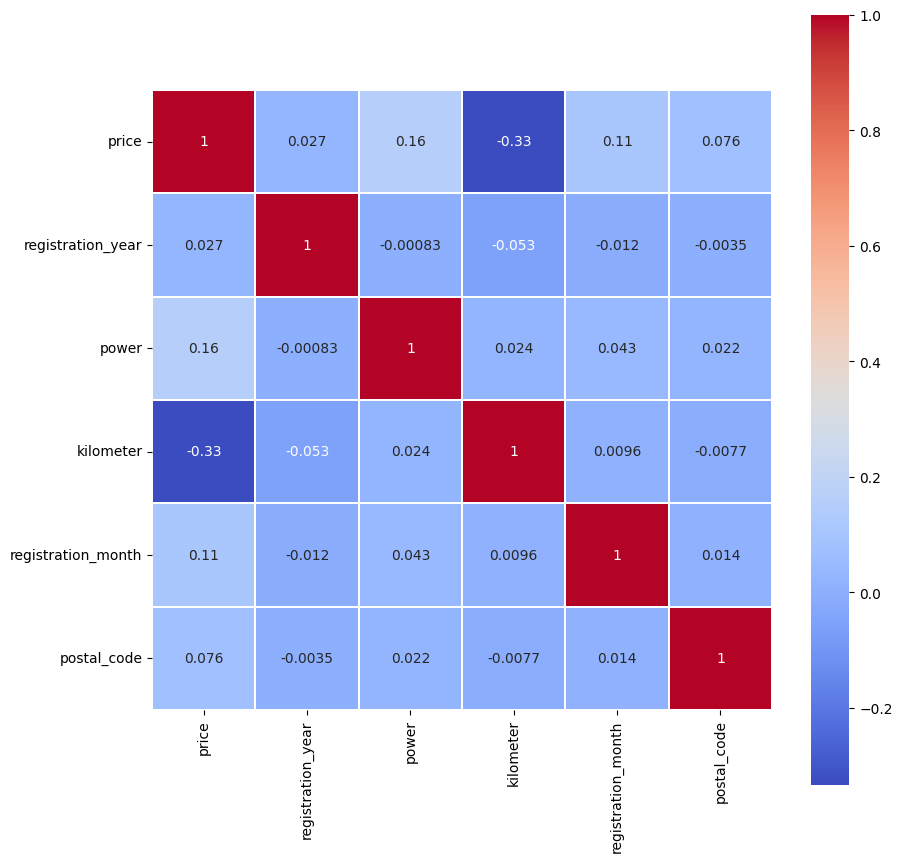

In [10]:
sd.cor_matrix(data.drop("number_of_pictures", axis=1))

### Вывод

Большое количество строк, время выполнения кода в ячейках выше среднего. Целевым признаком является price, что необходимо учесть на этапе предобработки. 
* Нулевые строки в столбцах price, power, registration_month. Нулевые строки в столбце number_of_picture больше 90%.
* Для последующей подготовки признаков к моделированию учтем, что столбцы vehicle_type, gearbox, model, registration_month, fuel_type, drand, repaired подлежат энкодированию. 
* В данных присутствует 4 явных дубликата. 
* Пропущенные значения в столбцах vehicle_type, gearbox, model, fuel_type, repaired. Пропущенные строки составляют больше половины датасета. 
* Тип данных не соответствует содержимому. data_crawled, data_created, last_seen - столбцы с датой. Для числовых столбцов возможно снизить размерность. 
* Год регистрации имеет аномальное максимальное и минимальное значения - 1000 и 9999, соответственно. Так же аномальное максимальное значение имеет столбец мощности.
* В данных числовых столбцов присутствуют выбросы.

## 2 Предобработка данных

In [11]:
data.drop_duplicates(inplace=True)
data.drop("number_of_pictures", axis=1, inplace=True)

In [12]:
date_columns = ["date_crawled", "date_created", "last_seen"]
data[date_columns] = data[date_columns].apply(
    pd.to_datetime, yearfirst=True, infer_datetime_format=True)

In [13]:
data.dtypes

date_crawled          datetime64[ns]
price                          int64
vehicle_type                  object
registration_year              int64
gearbox                       object
power                          int64
model                         object
kilometer                      int64
registration_month             int64
fuel_type                     object
brand                         object
repaired                      object
date_created          datetime64[ns]
postal_code                    int64
last_seen             datetime64[ns]
dtype: object

In [14]:
data[pd.DatetimeIndex(
    data["date_crawled"]).year - data["registration_year"] < 0].head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code,last_seen
22,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23,49716,2016-03-31 01:16:33
26,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10,31139,2016-03-16 09:16:46
48,2016-03-25 14:40:12,7750,NaN,2017,manual,80,golf,100000,1,petrol,volkswagen,NaN,2016-03-25,48499,2016-03-31 21:47:44
51,2016-03-07 18:57:08,2000,NaN,2017,manual,90,punto,150000,11,gasoline,fiat,yes,2016-03-07,66115,2016-03-07 18:57:08
57,2016-03-10 20:53:19,2399,NaN,2018,manual,64,other,125000,3,NaN,seat,no,2016-03-10,33397,2016-03-25 10:17:37


In [15]:
data.drop(data[pd.DatetimeIndex(
    data["date_crawled"]).year - data["registration_year"] < 0].index, 
          axis=0, inplace=True)

In [16]:
data['repaired'].fillna("no", inplace=True)

In [17]:
data.dtypes

date_crawled          datetime64[ns]
price                          int64
vehicle_type                  object
registration_year              int64
gearbox                       object
power                          int64
model                         object
kilometer                      int64
registration_month             int64
fuel_type                     object
brand                         object
repaired                      object
date_created          datetime64[ns]
postal_code                    int64
last_seen             datetime64[ns]
dtype: object

In [18]:
data = data.query("(price > 0)&(7 < power < 1600)&(registration_year > 1911)&(registration_month != 0)")   

In [19]:
cols_for_fill = ["gearbox", "model", "vehicle_type", "fuel_type"]
for i in range(len(cols_for_fill)):
    data[cols_for_fill[i]] = data[cols_for_fill[i]].fillna(
        (data.groupby(["brand", "power"]+cols_for_fill[:i])[cols_for_fill[i]]\
                                .transform(
        lambda x: x.mode()[0] if not x.mode().empty else np.nan
            )
        ))
    data = data[data[cols_for_fill[i]].notna()]

In [20]:
sd.deep_info(data)[1]

,rows,null_row,uniq,dup_val,dup_row,NaN,"NaN,%",type,mean,std,min,25%,50%,75%,max,outliers
date_crawled,275943,0,224137,51806,1,0,0.000%,datetime64[ns],nan,nan,nan,nan,nan,nan,nan,False
price,275943,0,3526,272417,1,0,0.000%,int64,5e+03,4.64e+03,1.0,1.45e+03,3.35e+03,7.2e+03,2e+04,True
vehicle_type,275943,0,8,275935,1,0,0.000%,object,nan,nan,nan,nan,nan,nan,nan,False
registration_year,275943,0,82,275861,1,0,0.000%,int64,2e+03,6.29,1.92e+03,2e+03,2e+03,2.01e+03,2.02e+03,False
gearbox,275943,0,2,275941,1,0,0.000%,object,nan,nan,nan,nan,nan,nan,nan,False
power,275943,0,493,275450,1,0,0.000%,int64,1.21e+02,57.3,8.0,79.0,1.13e+02,1.5e+02,1.6e+03,True
model,275943,0,249,275694,1,0,0.000%,object,nan,nan,nan,nan,nan,nan,nan,False
kilometer,275943,0,13,275930,1,0,0.000%,int64,1.28e+05,3.67e+04,5e+03,1.25e+05,1.5e+05,1.5e+05,1.5e+05,False
registration_month,275943,0,12,275931,1,0,0.000%,int64,6.38,3.35,1.0,4.0,6.0,9.0,12.0,False
fuel_type,275943,0,7,275936,1,0,0.000%,object,nan,nan,nan,nan,nan,nan,nan,False


In [21]:
data.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code,last_seen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,a4,125000,5,gasoline,audi,yes,2016-03-24,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,2016-03-14,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,33775,2016-04-06 19:17:07


In [22]:
1 - data.shape[0] / info.iloc[0, 0] 

0.22131168358406073

### Вывод

Удалены дубликаты строк, удален столбец "number_of_pictures", так как он не содержит информации и не вносит полезный вклад в модель.
Удалены строки с неправильными годами регистрации автомобилей. Сравнение года регистрации с годом, указанным в столбце "date_crawled", позволило исключить ошибочные данные. Пропущенные значения в столбце "repaired" были заполнены "no", следуя логике, что отсутствие информации о восстановлении может означать, что автомобиль не был подвергнут ремонту или не требовал восстановления. Пропущенные значения в остальных столбцах заполненены наиболее частым значением в группе по соответствующим признакам. Произведена фильтрация данных, оставив только те записи, где цена автомобиля больше 0, мощность находится в диапазоне от 7 до 1600 л.с. и год регистрации страше 1911. Цена выше нуля позволяет исключить автомобили, у которых цена неизвестна или некорректна. Минимальный год регистрации и минимальная мощность соответствуют первому автомобилю с механической коробкой передач. Максимальная мощность соответсвует Bugatti Chiron Super Sport 300+ с 

Удаленные строки составляют около 22% от изначального количества строк.


## 3 Подготовка выборки

In [23]:
data.drop(['date_crawled','date_created',
'postal_code','last_seen', 'registration_month'], axis=1, inplace=True)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop("price", axis=1), data["price"], random_state=RANDOM_STATE)

In [25]:
data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1,18300,coupe,2011,manual,190,a4,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


In [26]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((206957, 9), (68986, 9), (206957,), (68986,))

In [27]:
X_train.select_dtypes("object").nunique()

vehicle_type      8
gearbox           2
model           249
fuel_type         7
brand            39
repaired          2
dtype: int64

In [28]:
X_train.nunique()

vehicle_type           8
registration_year     78
gearbox                2
power                466
model                249
kilometer             13
fuel_type              7
brand                 39
repaired               2
dtype: int64

In [29]:
X_train.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
237676,wagon,2007,auto,435,other,150000,petrol,audi,no
215275,small,2009,manual,99,jazz,80000,petrol,honda,no
2700,coupe,2000,manual,115,astra,150000,petrol,opel,yes
199386,coupe,2012,auto,204,c_klasse,50000,petrol,mercedes_benz,yes
105720,sedan,2011,manual,136,e_klasse,80000,gasoline,mercedes_benz,no


In [30]:
# merge OHE-method and scaler 
encoder_scale = make_column_transformer(
    (OneHotEncoder(drop="first", dtype="uint8", sparse_output=False), 
    ["vehicle_type","gearbox", "fuel_type", "repaired"]),
    (BinaryEncoder(), 
    ["model", "brand"]),
    (RobustScaler(),["power","kilometer"]),
    remainder="passthrough",
    verbose_feature_names_out=False
)
# output is dataframe
encoder_scale.set_output(transform="pandas")
# apply method
X_train = encoder_scale.fit_transform(X_train)

In [31]:
X_train.head()

,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,gearbox_manual,fuel_type_electric,fuel_type_gasoline,...,model_7,brand_0,brand_1,brand_2,brand_3,brand_4,brand_5,power,kilometer,registration_year
237676,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,4.600000,0.0,2007
215275,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,-0.200000,-2.8,2009
2700,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,1,1,0.028571,0.0,2000
199386,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1.300000,-4.0,2012
105720,0,0,0,1,0,0,0,1,0,1,...,1,0,0,0,1,0,0,0.328571,-2.8,2011


In [32]:
X_train = sd.change_data(X_train)
X_train.dtypes

vehicle_type_convertible      uint8
vehicle_type_coupe            uint8
vehicle_type_other            uint8
vehicle_type_sedan            uint8
vehicle_type_small            uint8
vehicle_type_suv              uint8
vehicle_type_wagon            uint8
gearbox_manual                uint8
fuel_type_electric            uint8
fuel_type_gasoline            uint8
fuel_type_hybrid              uint8
fuel_type_lpg                 uint8
fuel_type_other               uint8
fuel_type_petrol              uint8
repaired_yes                  uint8
model_0                       int64
model_1                       int64
model_2                       int64
model_3                       int64
model_4                       int64
model_5                       int64
model_6                       int64
model_7                       int64
brand_0                       int64
brand_1                       int64
brand_2                       int64
brand_3                       int64
brand_4                     

## Вывод

Было выполнено удаление столбцов из исходного набора данных, таких как "date_crawled", "date_created", "postal_code", "last_seen" и "registration_month". Столбцы содержали информацию, которая не является значимой для предсказания цены автомобиля. Было выполнено разделение данных на обучающую (X_train, y_train) и тестовую (X_test, y_test) выборки с использованием функции train_test_split. Создан объекта encoder_scale, который объединяет два метода преобразования данных: One-Hot Encoding (OHE) и масштабирование признаков (RobustScaler). OHE применяется к категориальным признакам ("vehicle_type", "gearbox", "fuel_type", "repaired"). Масштабирование применяется к числовым признакам ("power", "kilometer"). Использование метода BinaryEncoder из библиотеки category_encoders для категориальных признаков "model" и "brand". Этот метод заменяет значения категориальных признаков их бинарными представлениями. Для уменьшения использования памяти были изменены типы данных для столбцов.



## 4 Обучение и тестирование модели

In [33]:
sampler = optuna.samplers.TPESampler(seed=10)

In [34]:
%%time
def get_better_model_1(trial):

    # create the statements with parameters for tha algorithms
    param_lgbm = {
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_leaves": trial.suggest_int("max_leaves", 5, 20),
        "random_state": RANDOM_STATE
    }
     # define the model
    regressor_obj = lgbm.LGBMRegressor(**param_lgbm)

 # hide our dataset behind cross_val_score and put there our metric
    metric_rmse = -cross_val_score(regressor_obj, X_train, y_train,
                                   scoring='neg_root_mean_squared_error',
                                   n_jobs=-1).mean()
    return metric_rmse

# Create a study object and optimize the objective function
study_lgbm = optuna.create_study(directions=["minimize"], sampler=sampler)
study_lgbm.optimize(get_better_model_1, n_trials=30, show_progress_bar=True)

[I 2023-05-31 15:01:59,867] A new study created in memory with name: no-name-b2b376dd-de46-4dd7-a71b-689303ac2e9b
c:\Anaconda3\envs\practicum\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-05-31 15:02:06,369] Trial 0 finished with value: 1692.953774593571 and parameters: {'max_depth': 8, 'n_estimators': 108, 'max_leaves': 15}. Best is trial 0 with value: 1692.953774593571.
[I 2023-05-31 15:02:13,003] Trial 1 finished with value: 1613.6952130220363 and parameters: {'max_depth': 8, 'n_estimators': 299, 'max_leaves': 8}. Best is trial 1 with value: 1613.6952130220363.
[I 2023-05-31 15:02:17,668] Trial 2 finished with value: 1930.0740083358382 and parameters: {'max_depth': 2, 'n_estimators': 404, 'max_leaves': 7}. Best is trial 1 with value: 1613.6952130220363.
[I 2023-05-31 15:02:21,247] Trial 3 finished with value: 2239.3881526525256 and parameters: {'max_depth': 1, 'n_estimators': 374, 'max_leaves': 20}. Best is trial 1 with value: 1613.6952130220363.
[I 2023-05-31 15:02:24,047] Trial 4 finished with value: 2252.7626804748875 and parameters: {'max_depth': 1, 'n_estimators': 305, 'max_leaves': 18}. Best is trial 1 with value: 1613.6952130220363.
[I 2023-05-31 15:02

In [35]:
%%time
def get_better_model_2(trial):

    # create the statements with parameters for tha algorithm
   
    param_xgb = {
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_leaves": trial.suggest_int("max_leaves", 5, 10),
        "random_state": RANDOM_STATE
    }
     # define the model
    regressor_obj = xgb.XGBRegressor(**param_xgb)

 # hide our dataset behind cross_val_score and put there our metric
    metric_rmse = -cross_val_score(regressor_obj, X_train, y_train,
                                   scoring='neg_root_mean_squared_error',
                                   n_jobs=-1).mean()
    return metric_rmse

# Create a study object and optimize the objective function
study_xgb = optuna.create_study(directions=["minimize"])
study_xgb.optimize(get_better_model_2, n_trials=10, show_progress_bar=True)

[I 2023-05-31 15:05:09,510] A new study created in memory with name: no-name-48846270-45e5-4bf4-bc88-d08fbbb46612


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-05-31 15:06:34,421] Trial 0 finished with value: 1627.8782706428642 and parameters: {'max_depth': 4, 'n_estimators': 415, 'max_leaves': 10}. Best is trial 0 with value: 1627.8782706428642.
[I 2023-05-31 15:06:51,778] Trial 1 finished with value: 1820.670343624794 and parameters: {'max_depth': 3, 'n_estimators': 102, 'max_leaves': 9}. Best is trial 0 with value: 1627.8782706428642.
[I 2023-05-31 15:07:15,490] Trial 2 finished with value: 1773.2673007919184 and parameters: {'max_depth': 3, 'n_estimators': 169, 'max_leaves': 10}. Best is trial 0 with value: 1627.8782706428642.
[I 2023-05-31 15:07:35,437] Trial 3 finished with value: 1889.576970410514 and parameters: {'max_depth': 2, 'n_estimators': 202, 'max_leaves': 10}. Best is trial 0 with value: 1627.8782706428642.
[I 2023-05-31 15:08:31,604] Trial 4 finished with value: 1567.0951213431167 and parameters: {'max_depth': 7, 'n_estimators': 144, 'max_leaves': 5}. Best is trial 4 with value: 1567.0951213431167.
[I 2023-05-31 15:09

In [36]:
%%time
def get_better_model_3(trial):

    # create the statements with parameters for tha algorithms
    param_tree = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'random_state': RANDOM_STATE
    }
    
     # define the model
    regressor_obj = DecisionTreeRegressor(**param_tree)

 # hide our dataset behind cross_val_score and put there our metric
    metric_rmse = -cross_val_score(regressor_obj, X_train, y_train,
                                   scoring='neg_root_mean_squared_error',
                                   n_jobs=-1).mean()
    return metric_rmse

# Create a study object and optimize the objective function
study_tree = optuna.create_study(directions=["minimize"], sampler=sampler)
study_tree.optimize(get_better_model_3, n_trials=50, show_progress_bar=True)

[I 2023-05-31 15:15:31,846] A new study created in memory with name: no-name-92ba9c4c-dcf2-4291-9e14-e9b2f8f0a8e1


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-05-31 15:15:33,449] Trial 0 finished with value: 2039.1076381413259 and parameters: {'max_depth': 9, 'min_samples_split': 11, 'min_samples_leaf': 10}. Best is trial 0 with value: 2039.1076381413259.
[I 2023-05-31 15:15:34,285] Trial 1 finished with value: 2594.699780235764 and parameters: {'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 0 with value: 2039.1076381413259.
[I 2023-05-31 15:15:34,861] Trial 2 finished with value: 3180.9700891697003 and parameters: {'max_depth': 2, 'min_samples_split': 17, 'min_samples_leaf': 1}. Best is trial 0 with value: 2039.1076381413259.
[I 2023-05-31 15:15:36,071] Trial 3 finished with value: 2179.278924684621 and parameters: {'max_depth': 7, 'min_samples_split': 12, 'min_samples_leaf': 9}. Best is trial 0 with value: 2039.1076381413259.
[I 2023-05-31 15:15:36,656] Trial 4 finished with value: 3180.9700891697003 and parameters: {'max_depth': 2, 'min_samples_split': 18, 'min_samples_leaf': 4}. Best is trial 0 with

In [45]:
best_model = study_lgbm.best_trial.params
best_model

{'max_depth': 10, 'n_estimators': 500, 'max_leaves': 9}

In [48]:
best_regressor = lgbm.LGBMRegressor(**best_model)
best_regressor.fit(X_train, y_train)
predictions = best_regressor.predict(encoder_scale.transform(X_test))
mean_squared_error(y_test, predictions, squared=False)

[LightGBM] [Warning] num_leaves is set=31, max_leaves=9 will be ignored. Current value: num_leaves=31


1579.7215003895617

### Вывод
Были выполнены оптимизации моделей LGBMRegressor, XGBoost и дерева решений с целью минимизации RMSE.

Лучшей моделью оказалась модель LGBMRegressor с параметрами: 'max_depth': 10, 'n_estimators': 500, 'max_leaves': 9.
Это обосновано следующими факторами:

Время выполнения: Используя параметры по умолчанию, модель LGBMRegressor имеет достаточно быструю скорость обучения и предсказания, что подтверждается временем выполнения кода. Оптимизация модели LGBMRegressor с помощью Optuna заняла всего лишь 3 минуты и 9 секунд, что является довольно быстрым результатом.

Качество модели: Лучшая модель LGBMRegressor, определенная с помощью Optuna, демонстрирует хорошие показатели качества предсказания цены на автомобили. Метрика RMSE (среднеквадратичная ошибка) для этой модели на тестовой выборке составила около 1579.72, что является низким значением и указывает на небольшую ошибку предсказания цены.




## 5 Заключение


### Вывод


В ходе работы были выполнены различные этапы предобработки и моделирования данных, с целью предсказания цен на автомобили. Были приняты во внимание особенности данных, включая обработку пропущенных значений, удаление дубликатов, фильтрацию аномалий и выбросов, а также преобразование категориальных признаков и масштабирование числовых признаков.

На этапе предобработки были удалены строки с нулевыми значениями в столбцах "price", "power" и "registration_month", а также удалены строки с более чем 90% нулевых значений в столбце "number_of_pictures". Дубликаты строк были удалены для повышения качества данных.

Категориальные признаки были закодированы с использованием метода BinaryEncoder, а числовые признаки были масштабированы с помощью RobustScaler. Дополнительно, для уменьшения использования памяти, были изменены типы данных для некоторых столбцов.

Для выбора оптимальной модели был использован алгоритм оптимизации параметров Optuna. Были протестированы модели LGBMRegressor, XGBoost и дерево решений, с целью минимизации RMSE (среднеквадратичная ошибка). В результате оптимизации, модель LGBMRegressor с параметрами 'max_depth': 10, 'n_estimators': 500, 'max_leaves': 9, показала лучшее качество предсказания цен на автомобили.

В целом, проделанная работа имеет следующую бизнесовую выгоду:

Более точные предсказания цен на автомобили помогут компании установить более конкурентоспособные цены и улучшить продажи.
Эффективная предобработка данных, включая заполнение пропущенных значений и удаление аномалий, позволяет получить более надежные и точные модели.
Оптимизация моделей с использованием Optuna позволяет выбрать наилучшие параметры для моделей, что приводит к повышению качества предсказаний и сокращению времени обучения модели.
Использование категориального кодирования и масштабирования признаков позволяет учесть особенности различных типов данных и повысить производительность модели.
Таким образом, проделанная работа по предсказанию цен на автомобили имеет значительную бизнесовую выгоду и способствует оптимизации процесса ценообразования и улучшению результатов продаж

